In [1]:
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from diffuser_utils.evaluate import evaluate_encoder, evaluate
from torchvision.models import convnext_base, convnext_small, efficientnet_v2_s

from accelerate import Accelerator
from diffusers import UNet1DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup

from eg3d_dataset import EG3DDataset
from eg3d_pipeline import EG3DPipeline
from eg3d_encoder import EG3DEncoder
from eg3d_loss import EG3DLoss
from eg3d import EG3D

from dataclasses import dataclass

from deepface import DeepFace

from SPIGA.inference.config import ModelConfig
from SPIGA.inference.framework import SPIGAFramework

import cv2

2023-02-24 01:26:06.704744: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pipeline = EG3DPipeline.from_pretrained("eg3d-latent-diffusion/diffuser/diffuser_139").to(torch.device('cuda'))

In [5]:
from eg3d import EG3D
eg3d = EG3D('eg3d/eg3d_model/ffhqrebalanced512-128.pkl', device='cuda')

In [6]:
dataset = 'wflw'
model_cfg = ModelConfig(dataset)
processor = SPIGAFramework(model_cfg)

SPIGA model loaded!


In [13]:
feature_keys = [{'Woman': 0, 'Man': 1}, {'asian': 0, 'indian': 1, 'black': 2, 'white': 3, 'middle eastern': 4, 'latino hispanic': 5}, {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}]

image_pth = '0020.png'
encoding = DeepFace.represent(img_path = image_pth, model_name = "Facenet512", enforce_detection=False)[0]['embedding']

image = cv2.imread(image_pth)
bbox = [0, 0, 512, 512]
features = processor.inference(image, [bbox])
landmarks = np.array(features['landmarks'][0])

analysis = DeepFace.analyze(img_path = image_pth, actions = ['age', 'gender', 'race', 'emotion'], silent=True, enforce_detection=False)[0]
age = torch.tensor([analysis['age']])
gender = F.one_hot(torch.tensor(feature_keys[0][analysis['dominant_gender']], dtype=torch.long), num_classes=2)
race = F.one_hot(torch.tensor(feature_keys[1][analysis['dominant_race']], dtype=torch.long), num_classes=6)
emotion = F.one_hot(torch.tensor(feature_keys[2][analysis['dominant_emotion']], dtype=torch.long), num_classes=7)

features = torch.zeros((512), dtype=torch.float32)
features[0] = age
features[1:3] = gender
features[3:9] = race
features[9:16] = emotion
features[16:212] = torch.from_numpy(landmarks.flatten())

image = cv2.imread(image_pth)
bbox = [0, 0, 512, 512]

print(analysis['age'])
print(analysis['dominant_gender'])
print(analysis['dominant_race'])
print(analysis['dominant_emotion'])

latent_vector = pipeline(torch.tensor(encoding).unsqueeze(0), torch.tensor(features).unsqueeze(0))[0]
# latent_vector = encoder(img.to('cuda'))[0]

26
Man
asian
sad


  0%|          | 0/1000 [00:00<?, ?it/s]

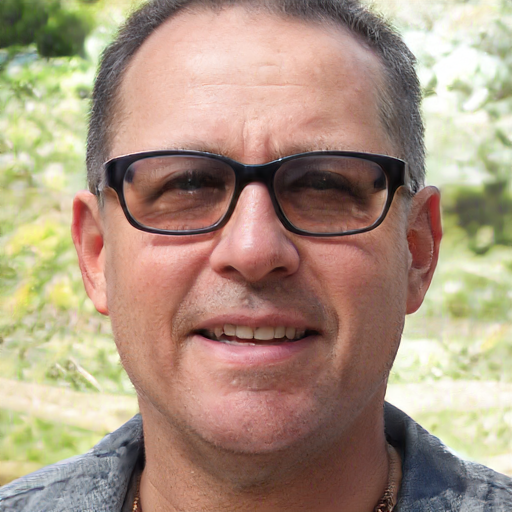

In [15]:
img = eg3d.generate_imgs(latent_vector.unsqueeze(0), transpose=True)[0].cpu().detach().numpy()
img = Image.fromarray((img*255).astype(np.uint8).clip(0, 255))
img.save('temp.png')
display(img)

In [16]:
analysis = DeepFace.analyze(img_path = 'temp.png', actions = ['age', 'gender', 'race', 'emotion'], silent=True, enforce_detection=False)[0]
print(analysis['age'])
print(analysis['dominant_gender'])
print(analysis['dominant_race'])
print(analysis['dominant_emotion'])

39
Man
white
happy
